#### Student Information
Name: Tan En En Amy

Student ID: 113401909

GitHub ID: amytan0107

Kaggle name: ⎛⎝(•ⱅ•)⎠⎞

Kaggle private scoreboard snapshot: 
![pic0.png](https://github.com/amytan0107/DM2024-Lab2-Homework/blob/main/pic0.png?raw=true)

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [13]:
### Begin Assignment Here

In [3]:
import pandas as pd  
import json  
import re 
import pandas as pd  
import numpy as np  
import torch  
from torch.utils.data import Dataset, DataLoader  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from sklearn.utils.class_weight import compute_class_weight  
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler 
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score  
import seaborn as sns  
import matplotlib.pyplot as plt  
from torch.cuda.amp import GradScaler, autocast  
from torch.optim import AdamW
from wordcloud import WordCloud

---
### Importing Data

In [4]:
# Load CSV files
data_identification_df = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')
emotion_df = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
sample_submission_df = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/sampleSubmission.csv')

# Load JSON lines file
tweets_data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        tweets_data.append(json.loads(line))

# Convert to a DataFrame
tweets_df = pd.DataFrame(tweets_data)

# Check the DataFrame
print(tweets_df.head())

   _score          _index                                            _source  \
0     391  hashtag_tweets  {'tweet': {'hashtags': ['Snapchat'], 'tweet_id...   
1     433  hashtag_tweets  {'tweet': {'hashtags': ['freepress', 'TrumpLeg...   
2     232  hashtag_tweets  {'tweet': {'hashtags': ['bibleverse'], 'tweet_...   
3     376  hashtag_tweets  {'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...   
4     989  hashtag_tweets  {'tweet': {'hashtags': [], 'tweet_id': '0x2de2...   

            _crawldate   _type  
0  2015-05-23 11:42:47  tweets  
1  2016-01-28 04:52:09  tweets  
2  2017-12-25 04:39:20  tweets  
3  2016-01-24 23:53:05  tweets  
4  2016-01-08 17:18:59  tweets  


In [5]:
# Extract the nested tweet information
tweets_df['_source'] = tweets_df['_source'].apply(lambda x: x['tweet'])  # Focus on the 'tweet' key within '_source'

# Flatten the nested structure
cleaned_tweets_df = pd.json_normalize(tweets_df['_source'])

# Keep only relevant columns
cleaned_tweets_df = cleaned_tweets_df[['tweet_id', 'text']]

# Check the cleaned DataFrame
print(cleaned_tweets_df.head())

   tweet_id                                               text
0  0x376b20  People who post "add me on #Snapchat" must be ...
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2  0x28b412  Confident of your obedience, I write to you, k...
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4  0x2de201  "Trust is not the same as faith. A friend is s...


In [6]:
# Merge tweet data with data identification information
merged_df = pd.merge(data_identification_df, cleaned_tweets_df, on='tweet_id', how='left')

# Merge with emotion labels for training data
train_df = merged_df[merged_df['identification'] == 'train']
train_df = pd.merge(train_df, emotion_df, on='tweet_id', how='left')

# Prepare the test data
test_df = merged_df[merged_df['identification'] == 'test']

---
#### EDA

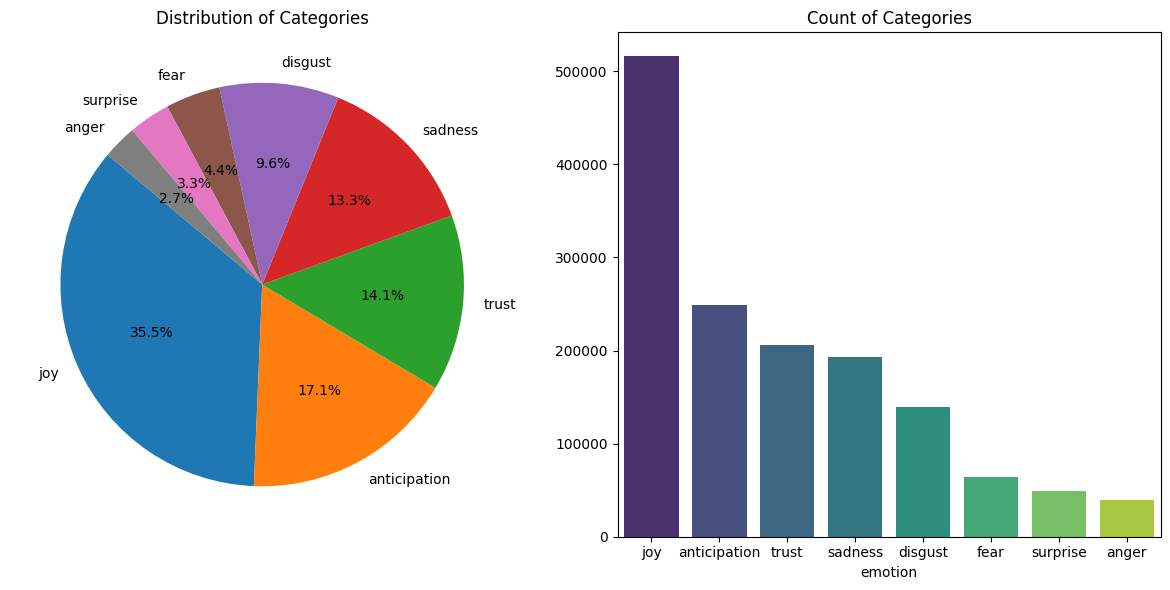

In [8]:
# Value Count Of Emotion
count = train_df['emotion'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Insight: The dataset exhibits a significant class imbalance, with 'joy' being the dominant class and 'anger' being underrepresented. To address this issue, I will incorporated class weights into the BERT model for sequence classification, which I will subseqeuntly explain.

In [9]:
# Make Seperate Data Set to Visualize text 

df_joy = train_df[train_df['emotion'] == 'joy']
df_anticipation = train_df[train_df['emotion'] == 'anticipation']
df_trust = train_df[train_df['emotion'] == 'trust']
df_sadness = train_df[train_df['emotion'] == 'sadness']
df_disgust = train_df[train_df['emotion'] == 'disgust']
df_fear = train_df[train_df['emotion'] == 'fear']
df_surprise = train_df[train_df['emotion'] == 'surprise']
df_anger = train_df[train_df['emotion'] == 'anger']

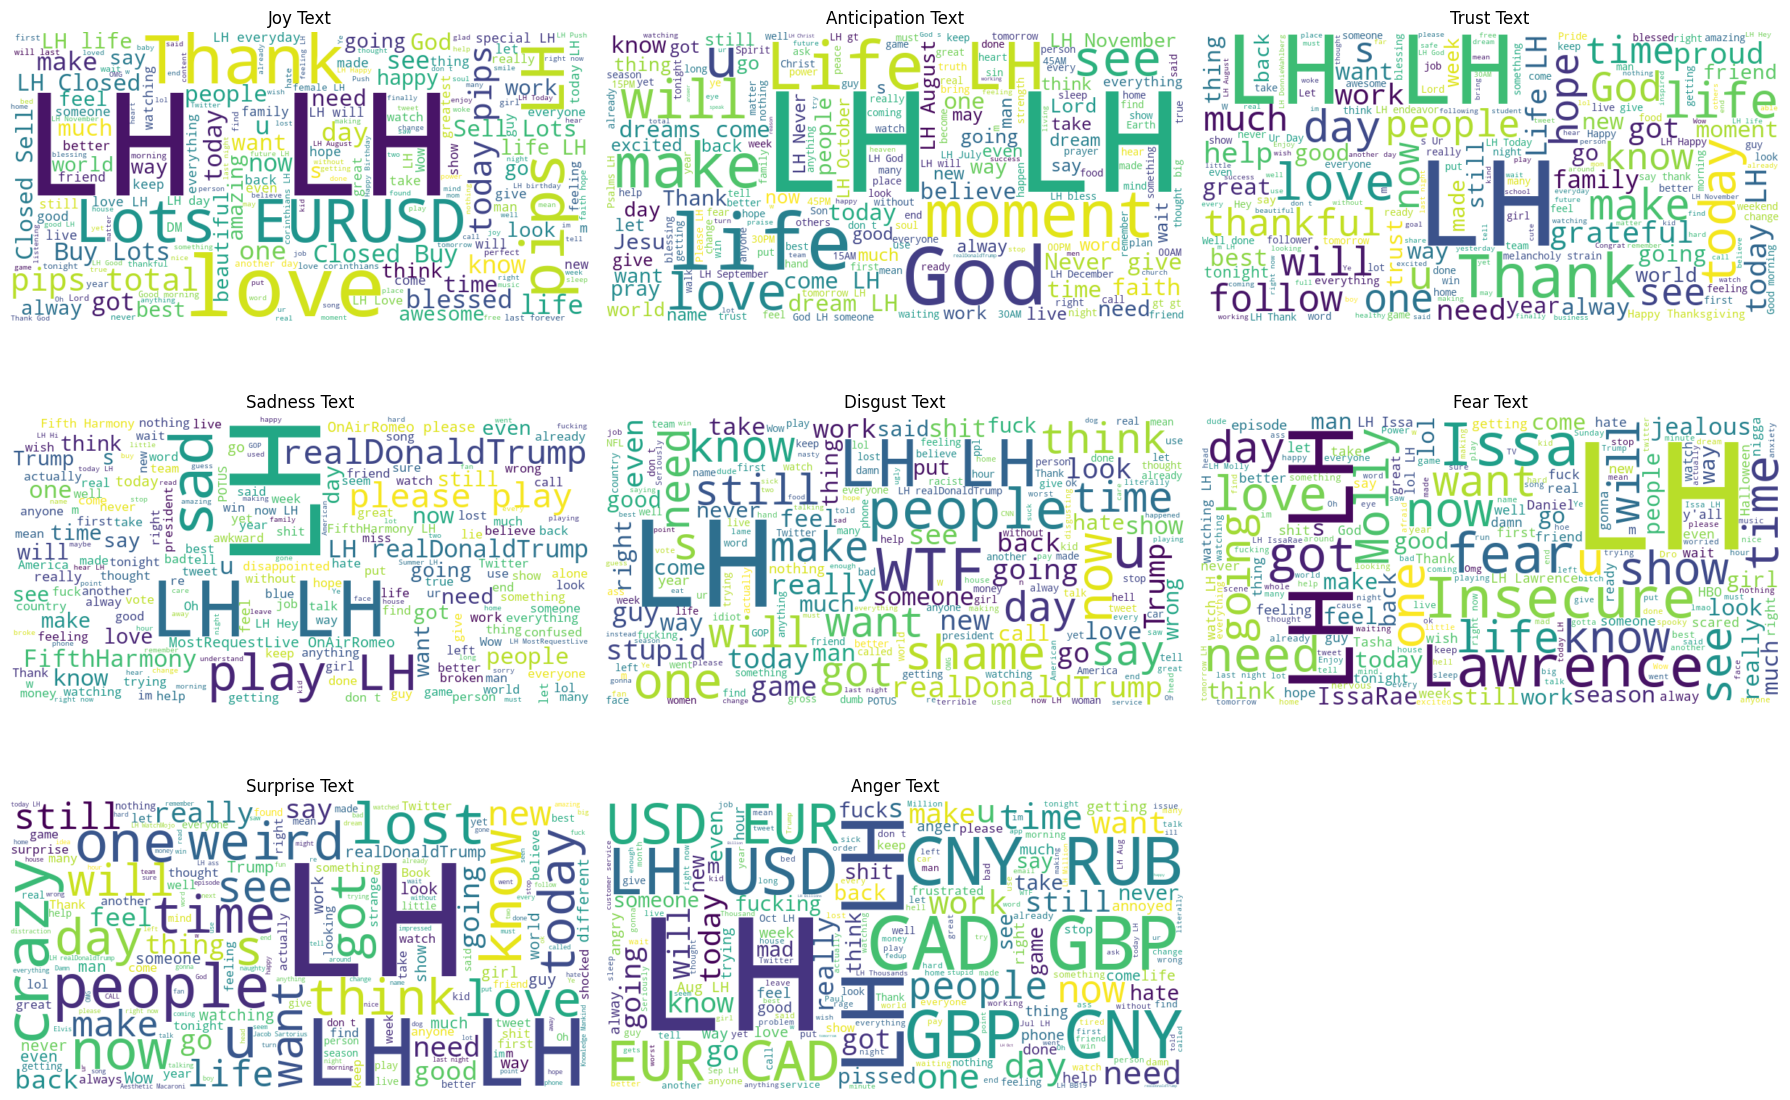

In [12]:
# Combine text from different categories
combined_joy_text = ' '.join(df_joy['text'])  # Assuming 'text' column contains the tweet text
combined_anticipation_text = ' '.join(df_anticipation['text'])
combined_trust_text = ' '.join(df_trust['text'])
combined_sadness_text = ' '.join(df_sadness['text'])
combined_disgust_text = ' '.join(df_disgust['text'])
combined_fear_text = ' '.join(df_fear['text'])
combined_surprise_text = ' '.join(df_surprise['text'])
combined_anger_text = ' '.join(df_anger['text'])

# Create word clouds for each emotion
joy_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_joy_text)
anticipation_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_anticipation_text)
trust_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_trust_text)
sadness_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_sadness_text)
disgust_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_disgust_text)
fear_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_fear_text)
surprise_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_surprise_text)
anger_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_anger_text)

# Plot the word clouds
plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
plt.imshow(joy_wordcloud, interpolation='bilinear')
plt.title('Joy Text')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(anticipation_wordcloud, interpolation='bilinear')
plt.title('Anticipation Text')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(trust_wordcloud, interpolation='bilinear')
plt.title('Trust Text')
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(sadness_wordcloud, interpolation='bilinear')
plt.title('Sadness Text')
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(disgust_wordcloud, interpolation='bilinear')
plt.title('Disgust Text')
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(fear_wordcloud, interpolation='bilinear')
plt.title('Fear Text')
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(surprise_wordcloud, interpolation='bilinear')
plt.title('Surprise Text')
plt.axis('off')

plt.subplot(3, 3, 8)
plt.imshow(anger_wordcloud, interpolation='bilinear')
plt.title('Anger Text')
plt.axis('off')

plt.tight_layout()
plt.show()

Insight: In the majority word cloud, I noticed the term “LH” (or < "LH” >), which in the Twitter context refers to a heart emoji. To clean the data, I replaced all instances with the actual heart emoji.

Additionally, I observed that some tweets contain ‘İ’ (a Turkish character), which may be interpreted as a symbol by the model rather than the letter ‘I’. Therefore, I replaced ‘İ’ with ‘I’ to improve accuracy.

---
### Data Cleaning

In [7]:
def clean_and_replace(text):    
    # Step 1: Replace <LH> with "heart"
    text = re.sub(r'(<LH>\s*)+', '❤️ ', text).strip()

    # Step 2: Replace 'İ' with 'I'
    text = text.replace('İ', 'I')

    # Step 3: Remove extra spaces
    text = ' '.join(text.split())

    return text

# Apply the function to clean the text in your dataframe
train_df['cleaned_text'] = train_df['text'].apply(clean_and_replace)

# Display the cleaned data
train_df

,tweet_id,identification,text,emotion,cleaned_text
0,0x29e452,train,Huge Respect🖒 @JohnnyVegasReal talking about l...,joy,Huge Respect🖒 @JohnnyVegasReal talking about l...
1,0x2b3819,train,Yoooo we hit all our monthly goals with the ne...,joy,Yoooo we hit all our monthly goals with the ne...
2,0x2a2acc,train,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,trust,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...
3,0x2a8830,train,Come join @ambushman27 on #PUBG while he striv...,joy,Come join @ambushman27 on #PUBG while he striv...
4,0x20b21d,train,@fanshixieen2014 Blessings!My #strength little...,anticipation,@fanshixieen2014 Blessings!My #strength little...
...,...,...,...,...,...
1455558,0x227e25,train,@BBCBreaking Such an inspirational talented pe...,disgust,@BBCBreaking Such an inspirational talented pe...
1455559,0x293813,train,And still #libtards won't get off the guy's ba...,sadness,And still #libtards won't get off the guy's ba...
1455560,0x1e1a7e,train,When you sow #seeds of service or hospitality ...,joy,When you sow #seeds of service or hospitality ...
1455561,0x2156a5,train,@lorettalrose Will you be displaying some <LH>...,trust,@lorettalrose Will you be displaying some ❤️ w...


In [6]:
test_df = test_df.copy()  # Create a copy to avoid modifying a view
test_df.loc[:, 'cleaned_text'] = test_df['text'].apply(clean_and_replace)
test_df

,tweet_id,identification,text,cleaned_text
0,0x28cc61,test,@Habbo I've seen two separate colours of the e...,@Habbo I've seen two separate colours of the e...
3,0x2db41f,test,@FoxNews @KellyannePolls No serious self respe...,@FoxNews @KellyannePolls No serious self respe...
15,0x2466f6,test,"Looking for a new car, and it says 1 lady owne...","Looking for a new car, and it says 1 lady owne..."
23,0x23f9e9,test,@cineworld “only the brave” just out and fount...,@cineworld “only the brave” just out and fount...
31,0x1fb4e1,test,Felt like total dog 💩 going into open gym and ...,Felt like total dog 💩 going into open gym and ...
...,...,...,...,...
1867495,0x2c4dc2,test,6 year old walks in astounded. Mum! Look how b...,6 year old walks in astounded. Mum! Look how b...
1867496,0x31be7c,test,Only one week to go until the #inspiringvolunt...,Only one week to go until the #inspiringvolunt...
1867500,0x1ca58e,test,"I just got caught up with the manga for ""My He...","I just got caught up with the manga for ""My He..."
1867515,0x35c8ba,test,Speak only when spoken to and make hot ass mus...,Speak only when spoken to and make hot ass mus...


---
### Save Data

In [7]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

### Train - Validation - Test split

In [8]:
X = train_df['cleaned_text'].values
y = train_df['emotion'].values

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

---
### Data Preprocessing and Loading

### One hot encoding

Converting categorical labels into numeric format is often necessary for machine learning models, especially when using models like BERT, which require numerical labels. This encoding ensures that the labels are consistent across training and validation sets, allowing the model to understand and predict the correct categories during training and evaluation.

In [10]:
# Initialize and fit the LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # Convert labels to numeric format
y_val = le.transform(y_val)         

### Calculate Class Weight

Incorporating class weights is particularly useful when working with imbalanced datasets, as it adjusts the loss function to penalize incorrect predictions on the minority class more than those on the majority class, helping to improve the model’s ability to correctly classify underrepresented classes.

In [11]:
class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

### PyTorch Dataset Definition

A custom PyTorch Dataset class was created to handle the input data and its associated labels.

This class ensures that the text data is tokenized correctly and formatted into input IDs and attention masks, which are necessary for BERT. It also returns the corresponding label for each tweet.

In [12]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

### Tokenizer Initialization

The use of BERT tokenizer ensures that the text is properly preprocessed for the BERT model, which expects tokenized input sequences with attention masks.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len = 128

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
test_df = test_df.reset_index(drop=True)

### Dataloader

The data loaders provide an efficient mechanism for batching and shuffling the data, making it ready for model training and evaluation.

Since test data typically does not have labels, the labels are set to [0] * len(test_df) as placeholders. This ensures the model can still receive the expected input format, even if the labels are not needed for testing.

In [15]:
train_loader = DataLoader(
    TweetDataset(X_train, y_train, tokenizer, max_len),
    batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(
    TweetDataset(X_val, y_val, tokenizer, max_len),
    batch_size=64, num_workers=4, pin_memory=True)

test_loader = DataLoader(
    TweetDataset(test_df['cleaned_text'], [0] * len(test_df), tokenizer, max_len),
    batch_size=64, num_workers=4, pin_memory=True)

---
### BERT Modeling

#### **Model Explanation**

For this task, I used the **BERT (Bidirectional Encoder Representations from Transformers)** model for sequence classification. BERT is a pre-trained transformer model that has proven highly effective for natural language processing tasks, including text classification.

1. **Pre-trained Model**:
   - I used the pre-trained **BERT-base-uncased** model, which is trained on a large corpus of text. It is capable of understanding the context of words in a sentence by looking at both the left and right context, making it well-suited for understanding the nuances of language in tweets.

2. **Fine-Tuning for Sequence Classification**:
- The BERT model is fine-tuned for sequence classification by adding a classification head (a fully connected layer) on top of the BERT model. This head outputs a probability distribution over the different classes for each input text.
- I fine-tuned this model on my specific dataset of tweets, which are labeled with various emotions.

3. **Class Weights**:
- Since there is a significant **class imbalance** in the dataset (with "joy" being the most frequent and "anger" being the least), I calculated **class weights** to address this issue.
- These class weights were incorporated into the **CrossEntropyLoss** function during training to penalize misclassifications of underrepresented classes more heavily, ensuring the model doesn’t bias towards the majority class.

4. **Optimizer**:
- I used **AdamW**, a variant of the Adam optimizer that is well-suited for training transformers, with a learning rate of `2e-5` and a weight decay factor to avoid overfitting.

5. **Mixed Precision Training**:
- I used **mixed precision training** with the help of `GradScaler`. This allows the model to use half-precision (float16) calculations when possible, speeding up training and reducing memory usage without compromising model accuracy.

6. **Scheduler**:
- A **linear learning rate scheduler** was employed, with a warm-up phase of 0 steps, ensuring the learning rate gradually increases and then decreases over time for better convergence during training.

7. **Training Strategy**:
- The model was trained for **3 epochs**, with early stopping to prevent overfitting. If the validation F1 score did not improve for 2 consecutive epochs, training was stopped early.

8. **Evaluation**:
- During training, the model’s performance was evaluated using the **F1 score** (weighted), which balances precision and recall, especially in imbalanced datasets. Other metrics such as **accuracy** and a **classification report** (including precision, recall, and F1 for each class) were used for comprehensive evaluation.

9. **Final Model**:
- After training, the best-performing model (based on validation F1 score) was saved for final evaluation, where metrics like the **confusion matrix** were used to analyze model performance across different emotion classes.

This approach leverages the power of the pre-trained BERT model while fine-tuning it to handle the specific characteristics of my tweet dataset, especially the class imbalance, and ensuring efficient and accurate model training through optimization techniques like class weighting and mixed precision.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(le.classes_))
model = model.to(device)

# Define loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scaler = GradScaler()

# Scheduler
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_23/4269652534.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### BERT Training

In [17]:
def train_epoch(model, data_loader, criterion, optimizer, scaler, device, scheduler):
    model.train()
    losses = []
    all_preds = []
    all_labels = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return np.mean(losses), f1

### BERT Validation

In [18]:
def eval_model(model, data_loader, criterion, device, class_names):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

            losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return np.mean(losses), f1, accuracy, report, conf_matrix

In [19]:
epochs = 3
best_f1 = 0
patience = 2
early_stop_counter = 0
class_names = le.classes_

for epoch in range(epochs):
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, scaler, device, scheduler)
    val_loss, val_f1, val_accuracy, val_report, val_conf_matrix = eval_model(model, val_loader, criterion, device, class_names)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

    if val_f1 > best_f1:
        best_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

/tmp/ipykernel_23/3147682421.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_23/3166315062.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3
Train Loss: 1.2539, Train F1: 0.5589
Val Loss: 1.1427, Val F1: 0.5875


/tmp/ipykernel_23/3147682421.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_23/3166315062.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/3
Train Loss: 1.0430, Train F1: 0.6189
Val Loss: 1.1172, Val F1: 0.6039


/tmp/ipykernel_23/3147682421.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_23/3166315062.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/3
Train Loss: 0.9018, Train F1: 0.6484
Val Loss: 1.1554, Val F1: 0.6158



Final Evaluation on Validation Set


/tmp/ipykernel_23/3166315062.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Final Validation Loss: 1.1554
Final Validation F1 Score: 0.6158
Final Validation Accuracy: 0.6026

Classification Report:
               precision    recall  f1-score   support

       anger       0.28      0.59      0.38      7973
anticipation       0.72      0.71      0.72     49787
     disgust       0.52      0.54      0.53     27820
        fear       0.46      0.69      0.55     12800
         joy       0.81      0.59      0.69    103204
     sadness       0.61      0.52      0.56     38687
    surprise       0.25      0.53      0.34      9746
       trust       0.52      0.61      0.57     41096

    accuracy                           0.60    291113
   macro avg       0.52      0.60      0.54    291113
weighted avg       0.65      0.60      0.62    291113



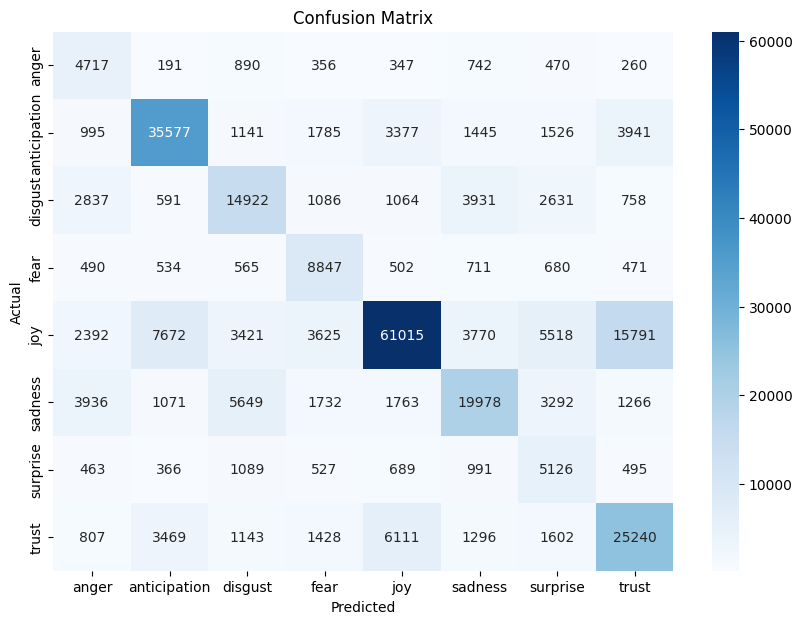

In [20]:
# Final evaluation after training is completed
print("\nFinal Evaluation on Validation Set")
final_val_loss, final_val_f1, final_val_accuracy, final_val_report, final_conf_matrix = eval_model(
    model, val_loader, criterion, device, class_names)

print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation F1 Score: {final_val_f1:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print("\nClassification Report:\n", final_val_report)

plt.figure(figsize=(10, 7))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Final Model Evaluation**

After completing the training and validation process, the model was evaluated on the validation set with the following final results:

- **Final Validation Loss**: **1.1554**  
  This value indicates the average loss across all validation batches. The loss measures how well the model's predictions match the true labels, with lower values indicating better model performance.

- **Final Validation F1 Score**: **0.6158**  
  The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics. A higher F1 score indicates that the model is performing well in both identifying positive instances and minimizing false positives/negatives. In this case, an F1 score of 0.6158 indicates a fairly balanced performance, but there's room for improvement, especially in handling the class imbalance.

- **Final Validation Accuracy**: **0.6026**  
  Accuracy measures the overall percentage of correct predictions. While an accuracy of 60.26% is reasonable, the model may benefit from further optimization, especially considering the class imbalance in the dataset.



These results suggest that while the model performs reasonably well on the validation set, there may still be room for improvement. Further tuning of hyperparameters, experimenting with different architectures, or applying additional techniques like data augmentation or advanced handling of class imbalance might help achieve better performance.

---
### BERT Prediction & Submission

In [21]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())

test_predictions = le.inverse_transform(test_predictions)

# Prepare submission file
submission = pd.DataFrame({
    'id': test_df['tweet_id'],  
    'emotion': test_predictions
})

submission.to_csv('/kaggle/working/submission.csv', index=False)

/tmp/ipykernel_23/1639159879.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


---
## Report: 
## Comparison of Old & New Method

### **Old Method: Bi-directional GRU Model with Tokenizer**

1. **Data Preprocessing and Text Cleaning**:
   In the previous approach, I focused on extensive data preprocessing to clean the text before feeding it into the model. This included removing mentions, URLs, hashtags, and special characters, as well as expanding common contractions. These steps were intended to reduce noise in the data and make it easier for the model to interpret the text. I also used the `Tokenizer` class from Keras to limit the vocabulary size and ensure that the model could handle only the most frequent words. While this helped to simplify the input, it may have caused some loss of information, particularly for longer or out-of-vocabulary words.

2. **Model Architecture**:
   The model used a **Bi-directional GRU (Gated Recurrent Unit)** architecture, which allowed the model to capture sequential dependencies in the text. However, this model was still based on handcrafted features, such as padding and sequence length limits, which may have restricted its ability to learn complex patterns from the data. Additionally, the embeddings were initialized with random weights, meaning the model had to learn representations from scratch, which limited its ability to understand nuanced language features from the start. The GRU layers, with 120 and 64 units, were chosen based on some assumptions about model complexity, but these settings might not have been optimal.

3. **Results**:
   The model achieved an **F1 score of 0.57** and an **accuracy of around 58.3%** on the test set. While the model did extract some useful features from the text, it struggled with more complex patterns and subtle emotional cues in the tweets, limiting its performance in terms of accurately classifying emotions. The results highlighted the challenges of relying solely on GRU-based architectures for this task.

![Image](https://i.imgur.com/9Y7lOWW.png)
---

### **New Method: BERT Model for Sequence Classification**

1. **Data Preprocessing**:
   In the new approach, while I still performed some basic preprocessing, the primary shift was towards using **BERT**. BERT, a pre-trained transformer-based model, comes with embeddings that are already fine-tuned on vast amounts of text data. This significantly reduces the need for manual feature engineering, as BERT understands the context and relationships between words. The text is tokenized into subwords (WordPiece tokens), allowing the model to handle even out-of-vocabulary words effectively. This shift to BERT’s pre-trained tokenizer directly leveraged its contextual understanding without the need for extensive cleaning or feature extraction.

2. **Model Architecture**:
   The model architecture was completely redesigned to leverage **BERT**’s self-attention mechanism, which enables it to capture complex relationships in the text by considering the entire context of a sentence at once. Unlike the GRU model, BERT is initialized with pre-trained weights, providing a rich understanding of language from the start, which is particularly beneficial for tasks like emotion detection. This change allowed the model to better capture the nuances and subtleties in the text.

3. **Class Weights and Loss Function**:
   To address the class imbalance in the dataset, I incorporated **class weights** into the loss function. This adjustment ensured that the model gave more importance to underrepresented classes, which improved its ability to classify emotions accurately, particularly for minority classes.

4. **Results**:
   After switching to BERT, I observed a significant improvement in performance. The F1 score increased to **0.6158** (a 5% improvement), and accuracy rose to **60.26%**. This improvement was also reflected in the **public Kaggle score**, which increased to **0.49686** (private score: 0.48207), compared to **0.43492** with the previous method. These results indicate that BERT’s ability to understand contextual relationships in language played a crucial role in improving the model’s performance.

#### Old Model:
![Image](https://i.imgur.com/utTWA39.png)

#### New Model:
![Image](https://i.imgur.com/Nt08x4V.png)
---

### **Summary of Improvements**:

1. **Improved Performance**:
   The transition to BERT resulted in significant improvements in both **F1 score** (from 0.57 to 0.6158) and **accuracy** (from 58.3% to 60.26%). Given the complexity of natural language processing tasks, especially sentiment/emotion detection, these improvements demonstrate the power of BERT in capturing the subtleties of language.

2. **Transfer Learning**:
   The main benefit of switching to BERT was the ability to leverage **transfer learning**. BERT had already been pre-trained on vast text corpora, allowing it to learn complex relationships and linguistic structures. By fine-tuning this pre-trained model on my specific dataset, I was able to significantly enhance performance without needing to start from scratch.

3. **Handling Class Imbalance**:
   The use of **class weights** allowed the model to better handle class imbalance in the dataset. This adjustment improved the model’s performance on minority classes, leading to a higher F1 score and more balanced predictions.

4. **Contextual Understanding**:
   BERT’s **self-attention mechanism** enabled it to capture long-range dependencies and contextual relationships in the text, which was a significant improvement over the GRU model. This ability to consider the entire context of a sentence allowed BERT to better understand the emotional tone of complex sentences.

---

### **Conclusion**:
By switching from a Bi-directional GRU model to BERT, I was able to significantly improve the model's performance in emotion detection tasks. The improvements in F1 score, accuracy, and Kaggle performance clearly demonstrate the value of using state-of-the-art models like BERT, which offer a deeper understanding of language and context. This transition also highlighted the importance of transfer learning and addressing class imbalance to achieve better results in real-world NLP tasks.